# How to use BulkLMM in R with JuliaConnectoR?

`JuliaConnectoR` is a package that enables the integration of Julia language into R programming. 
With `JuliaConnectoR`, users can execute Julia commands and functions within R, utilizing Julia's 
high-performance computing capabilities while still working within the familiar R environment. 
The package provides seamless communication between the two languages, allowing for data to be 
passed between R and Julia with ease. `JuliaConnectoR` also provides for the installation of Julia 
packages from within R, making it a convenient tool for those looking to leverage the power 
of Julia while still utilizing R as their primary programming language.   

*Note: [Link to the documentation of the package `JuliaConnectoR`](https://github.com/stefan-m-lenz/JuliaConnectoR?tab=readme-ov-file).*

## Overview

In this example, we'll showcase the use of the usage of `BulkLMM.jl`.

In [1]:
# load necessary library
library(JuliaConnectoR)
# library(dplyr)
# library(stats)
# library(MASS)
# library(ggplot2)
# library(reshape2)
# library(gridExtra)

### Example - BXD 

## Data Generation

Our dataset is made up of a dataframe `X` that includes a single predictor. This predictor is ordinal data with `5 levels`, distributed over `n = 100` samples. Next, we define a response dataframe `Y` that consists of `m = 250` responses. 
In order to simulate the `Y` data, we need to construct the matrices `Z`, `B`, and `E`.
The `Z` matrix imparts information about the response population, represented by the columns of `Y`, $y_{i \in [1, 250]}$. This matrix is given dimensions of `250x4`.

In accordance with this configuration, our coefficient matrix `B` is set to have dimensions of `4x5`, aligning with the number of predictors in the design matrix `X` and the number of information categories in `Z`.

Lastly, we formulate the noise matrix E that accommodates the error terms. This matrix is produced as a normally distributed matrix ($N, 0, 1$), introducing a degree of variability into our simulation.

## Environment and libraries

Create a Julia project environment:

In [5]:
juliaEval('using Pkg')
juliaEval('Pkg.activate(".")')

Install `BigRiverQTL` if it is not already installed in Julia:

In [7]:
juliaEval('Pkg.add("BigRiverQTL")')

Install `Plots` for the visualization:

In [9]:
juliaEval('Pkg.add("Plots")')

Load the library `BigRiverQTL`:

In [10]:
 juliaEval('using BigRiverQTL')

In [23]:
# load BigRiverQTL features available in R
BigRiverQTL <- juliaImport("BigRiverQTL")

### Data

In [22]:
########
# Data #
########
# data_dir = joinpath(@__DIR__, "../data/BXD/");
# file = joinpath(data_dir, "bxd.json");

# get path of data example from the package
pathBigRiverQTL <- juliaEval('pathof(BigRiverQTL) |> dirname |>dirname')
data_path <- file.path(pathBigRiverQTL, "test", "data", "BXD", "bxd.json")  

# check if path is correct
data_path |> file.exists()

[1] TRUE

In [27]:
data_path

[1] "/home/faragegr/.julia/packages/BigRiverQTL/z5aDD/test/data/BXD/bxd.json"

Load bxd data using the function `get_geneticstudydata()`: 

In [ ]:
# Load bxd data
# data <- BigRiverQTL$get_geneticstudydata(data_path)
juliaEval('get_geneticstudydata("/home/faragegr/.julia/packages/BigRiverQTL/z5aDD/test/data/BXD/bxd.json")')

In [ ]:
# The current version of `BigRiverQTL` does not have imputation functions.
# Remove the  missing data
data <- BigRiverQTL$get_data_completecases(data);

In [ ]:
# Data types
# gmap contains 
# makers info 
gInfo = data.gmap;

# phenotype info 
pInfo = data.phenocov;
# phenotype values 
pheno = data.pheno.val;

# We can get the genotype matrix using the following command.
# For computing reasons, we need to convert the geno matrix in Float64.
# One way to do it is to multiply by 1.0
geno = reduce(hcat, data.geno.val).*1.0;

#### Preprocessing

In [ ]:
#################
# Preprocessing #
#################
traitID = 1112;
pheno_y = pheno[:, traitID];
pheno_y2 = ones(length(pheno_y));
idx_not_missing = findall(!ismissing, pheno_y)
pheno_y2[idx_not_missing] = pheno_y[idx_not_missing];

#### Kinship

In [ ]:
###########
# Kinship #
###########
kinship = kinship_gs(geno,.99);

#### Scan

In [ ]:
########
# Scan #
########

single_results_perms = scan(
	pheno_y2,
	geno,
	kinship;
	permutation_test = true,
	nperms = 1000,
);

#### Plots

In [ ]:
#########
# Plots #
#########

# QTL plots
plot_QTL(single_results_perms, gInfo, mbColname = "Pos")
# savefig(joinpath(@__DIR__, "..", "images", "QTL_thrs_example.png"))

In [ ]:
# Manhattan plots
plot_manhattan(single_results_perms, gInfo, mbColname = "Pos")
savefig(joinpath(@__DIR__, "..", "images", "manhattan_thrs_example.png"))

In [4]:
# Load necessary library
library(dplyr)

# Dimensions of matrices
n <- 100
m <- 250

# Number of groupings designed in the Z matrix
q <- 4

# Generate data with 1 ordinal categorical variable
set.seed(123)  # For reproducibility
dfX <- data.frame(catvar = factor(sample(1:5, n, replace = TRUE), levels = c("1", "2", "3", "4", "5")))

# Get unique levels of the categorical variable
levels_catvar <- sort(unique(dfX$catvar))

# Generate additional numeric variables
dfX <- cbind(dfX, as.data.frame(matrix(runif(n * 3), nrow = n)))
colnames(dfX)[2:4] <- c("var3", "var4", "var5")

# Display the first few rows
head(dfX)


,catvar,var3,var4,var5
,<fct>,<dbl>,<dbl>,<dbl>
1,3,0.3124482,0.13710608,0.7608236
2,3,0.7082903,0.39658459,0.3727094
3,2,0.2650178,0.22498533,0.7691939
4,2,0.5943432,0.05795856,0.5376772
5,3,0.4812898,0.39589269,0.9139954
6,5,0.2650327,0.06492830,0.1852964


We employ the `design_matrix()` function to derive the predictor design matrix and apply contrast coding using the `SeqDiffCoding()` system. This coding system is particularly useful for testing hypotheses related to "sequential differences" between the levels of our ordinal predictor.

In [5]:
contrast.seqdiff <- juliaEval('MatrixLM.StatsModels.ContrastsMatrix(MatrixLM.StatsModels.SeqDiffCoding(), ["1", "2", "3", "4", "5"]).matrix');

In [6]:
X <- model.matrix(~ catvar, data = dfX, contrasts = list(catvar = contrast.seqdiff));
head(X)

,(Intercept),catvar1,catvar2,catvar3,catvar4
1,1,0.2,0.4,-0.4,-0.2
2,1,0.2,0.4,-0.4,-0.2
3,1,0.2,-0.6,-0.4,-0.2
4,1,0.2,-0.6,-0.4,-0.2
5,1,0.2,0.4,-0.4,-0.2
6,1,0.2,0.4,0.6,0.8


We randomly generate a dataframe `Z` that provides information about whether a response $y_{i \in [1, 250]}$, i.e., a column of `Y`, exhibits one of the four mutually exclusive attributes `{"A", "B", "C", "D"}`. To extract the design matrix of this "column predictor," we use the `design_matrix()` function and implement contrast coding with the `FullDummyCoding()` system.

The `FullDummyCoding` system generates one indicator (1 or 0) column for each level, including the base level. This technique is sometimes referred to as one-hot encoding, which is widely used for categorical variables.


In [7]:
dfZ <- data.frame(attribute = sample(c("A", "B", "C", "D"), m, replace = TRUE))

In [8]:
contrast.fulldummy <- juliaEval('MatrixLM.StatsModels.ContrastsMatrix(MatrixLM.StatsModels.FullDummyCoding(), ["A", "B", "C", "D"]).matrix');
Z <- model.matrix(~ 0 + attribute, data = dfZ, contrasts = list(attribute = contrast.fulldummy));
head(Z)

,attributeA,attributeB,attributeC,attributeD
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,1,0,0,0
5,0,0,0,1
6,0,1,0,0


The error matrix `E` is obtained as follows:

In [9]:
# Generate noise matrix E
E <- matrix(rnorm(n * m) * 4, nrow = n, ncol = m)

We intentionally structure the coefficient matrix `B` according to a distinct pattern. By doing so, we enable a more straightforward visualization and interpretation of the results in the following steps:

In [10]:
# Define the (p, q) matrix B
B <- matrix(c(
  20.0,  10.0, 15.0, 12.0,
  0.01,  7.0,  0.05, 0.01,
  12.0,  0.1,  0.05, 0.5,
  0.01,  12.0, 0.05, 0.03,
  0.07,  0.0,  8.5,  0.04
), nrow = 5, byrow = TRUE)

Generate the response matrix `Y`:

In [11]:
# Compute response matrix Y
Y <- X %*% B %*% t(Z) + E

Now, construct the `RawData` object consisting of the response variable `Y` and row/column predictors `X` and `Z`. All three matrices must be passed in as 2-dimensional arrays. You have the option to specify if `X` and `Z` include an intercept (true) or not (false). If this information is not provided, the default setting is assumed to be false (no intercept).

In [12]:
# Construct a RawData object
dat <- MatrixLM$RawData(MatrixLM$Response(Y), MatrixLM$Predictors(X, Z, TRUE, FALSE))

## Model estimation

Least-squares estimates for matrix linear models can be obtained by running `mlm`. An object of type `Mlm` will be returned, with variables for the coefficient estimates (`B`), the coefficient variance estimates (`varB`), and the estimated variance of the errors (`sigma`). By default, `mlm` estimates both row and column main effects (X and Z intercepts), but this behavior can be suppressed by setting `addXIntercept=false` and/or `addZIntercept=false`. Column weights for `Y` and the target type for variance shrinkage<sup>[1](#myfootnote1)</sup> can be optionally supplied to `weights` and `targetType`, respectively. 

In [13]:
est <- MatrixLM$mlm(dat, addXIntercept= TRUE, addZIntercept = FALSE) # Model estimation

## Model predictions and residuals

The coefficient estimates can be accessed using `coef(est)`. Predicted values and residuals can be obtained by calling `predict()` and `resid()`. By default, both of these functions use the same data used to fit the model. However, a new `Predictors` object can be passed into `predict()` as the `newPredictors` argument and a new `RawData` object can be passed into `resid()` as the newData argument. For convenience, `fitted(est)` will return the fitted values by calling predict with the default arguments.


In [14]:
esti_coef <- MatrixLM$coef(est); # Get the coefficients of the model

To compare the estimated coefficients with the original matrix `B`, we will visualize the matrices using heatmaps. This graphical representation allows us to readily see differences and similarities between the two.

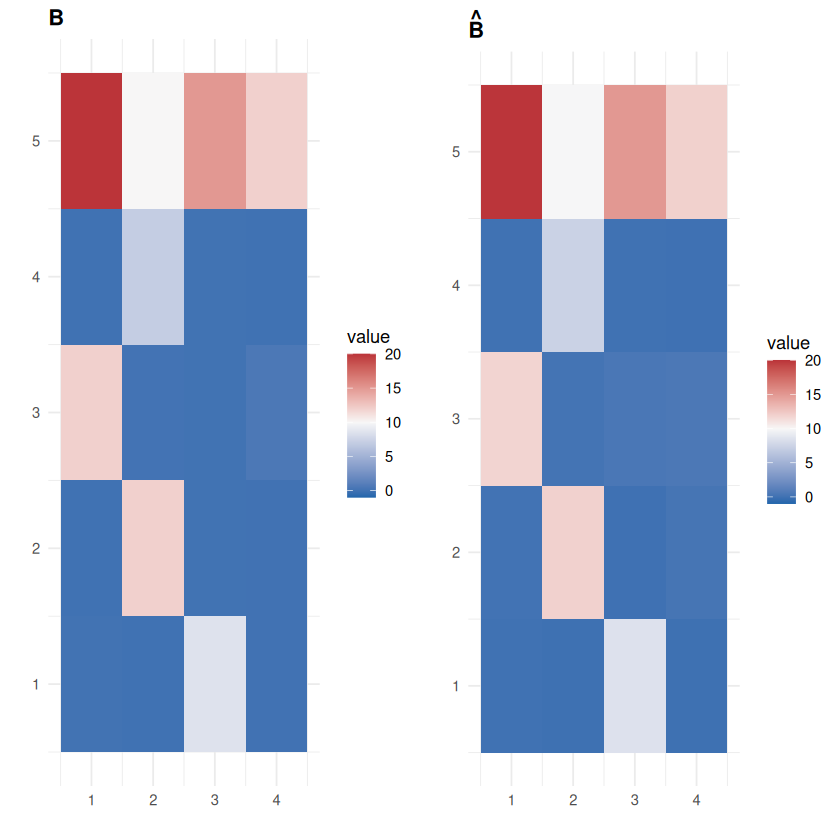

In [15]:
# Convert matrices to data frames for ggplot
rng = range(c((B), (esti_coef)))
df_B <- melt(B)
df_esti_coef <- melt(esti_coef)

# Reverse row order (equivalent to Julia's end:-1:1)
df_B$Var1 <- rev(df_B$Var1)
df_esti_coef$Var1 <- rev(df_esti_coef$Var1)

# Create heatmap plots
p1 <- ggplot(df_B, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low="#2166ac", mid="#f7f7f7", high="#b2182b", #colors in the scale
               midpoint=mean(rng),    #same midpoint for plots (mean of the range)
               # breaks=seq(0,1,0.25), #breaks in the scale bar
               limits=c(floor(rng[1]), ceiling(rng[2]))) +
    # scale_fill_gradient2(low = "blue", mid = "white", high = "red") +
    theme_minimal() +
    labs(title = expression(bold(B)), x = "", y = "")

p2 <- ggplot(df_esti_coef, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low="#2166ac", mid="#f7f7f7", high="#b2182b", #colors in the scale
                   midpoint=mean(rng),    #same midpoint for plots (mean of the range)
                   # breaks=seq(0,1,0.25), #breaks in the scale bar
                   limits=c(floor(rng[1]), ceiling(rng[2]))) +
    # scale_fill_gradient2(low = "blue", mid = "white", high = "red") +
    theme_minimal() +
    labs(title = expression(bold(hat(B))), x = "", y = "")

# Arrange plots side by side
grid.arrange(p1, p2, ncol = 2)

Let's employ the same visualization method to compare the predicted values with the original `Y` response matrix. This allows us to gauge the accuracy of our model predictions.

In [16]:
preds <-  MatrixLM$predict(est); # Prediction value

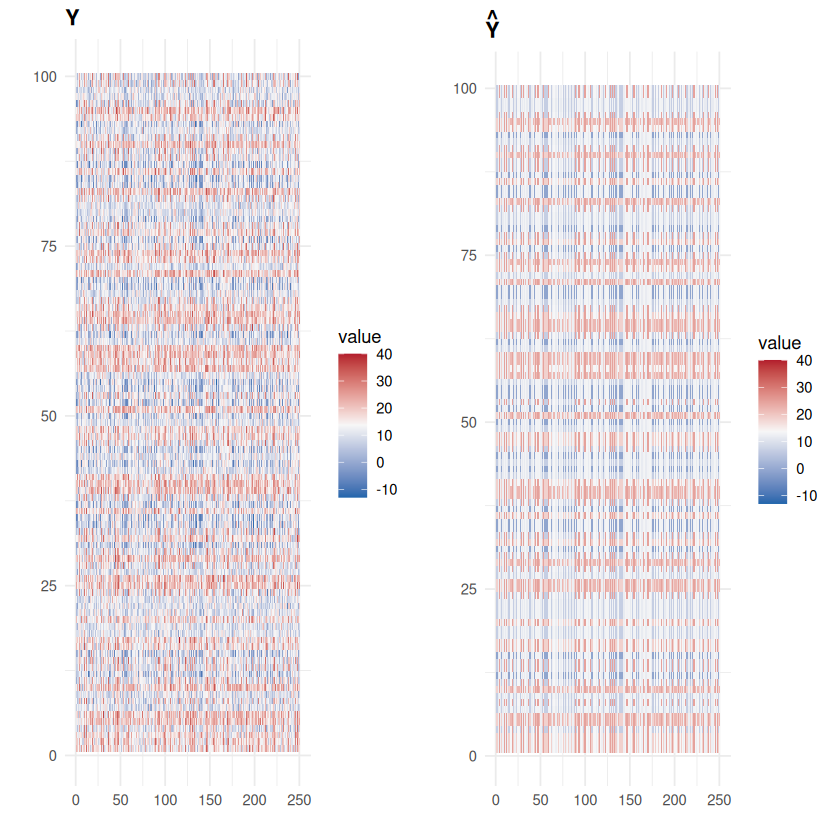

In [17]:
# Convert matrices to data frames for ggplot
rng = range(c((Y), (preds$Y)))
df_Y <- melt(Y)
df_Y_esti <- melt(preds$Y)

# Reverse row order (equivalent to Julia's end:-1:1)
df_Y$Var1 <- rev(df_Y$Var1)
df_Y_esti$Var1 <- rev(df_Y_esti$Var1)

# Create heatmap plots
p3 <- ggplot(df_Y, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low="#2166ac", mid="#f7f7f7", high="#b2182b", #colors in the scale
                   midpoint=mean(rng),    #same midpoint for plots (mean of the range)
                   limits=c(floor(rng[1]), ceiling(rng[2]))) +
    theme_minimal() +
labs(title = expression(bold(Y)), x = "", y = "")

p4 <- ggplot(df_Y_esti, aes(x = Var2, y = Var1, fill = value)) +
    geom_tile() +
    scale_fill_gradient2(low="#2166ac", mid="#f7f7f7", high="#b2182b", #colors in the scale
                   midpoint=mean(rng),    #same midpoint for plots (mean of the range)
                   limits=c(floor(rng[1]), ceiling(rng[2]))) +
    theme_minimal() +
    labs(title = expression(bold(hat(Y))), x = "", y = "")

# Arrange plots side by side
grid.arrange(p3, p4, ncol = 2)

The `resid()` function, available in `MatrixLM.jl`, provides us with the ability to compute residuals for each observation, helping you evaluate the discrepancy between the model's predictions and the actual data.

In [18]:
resids <-  MatrixLM$resid(est)

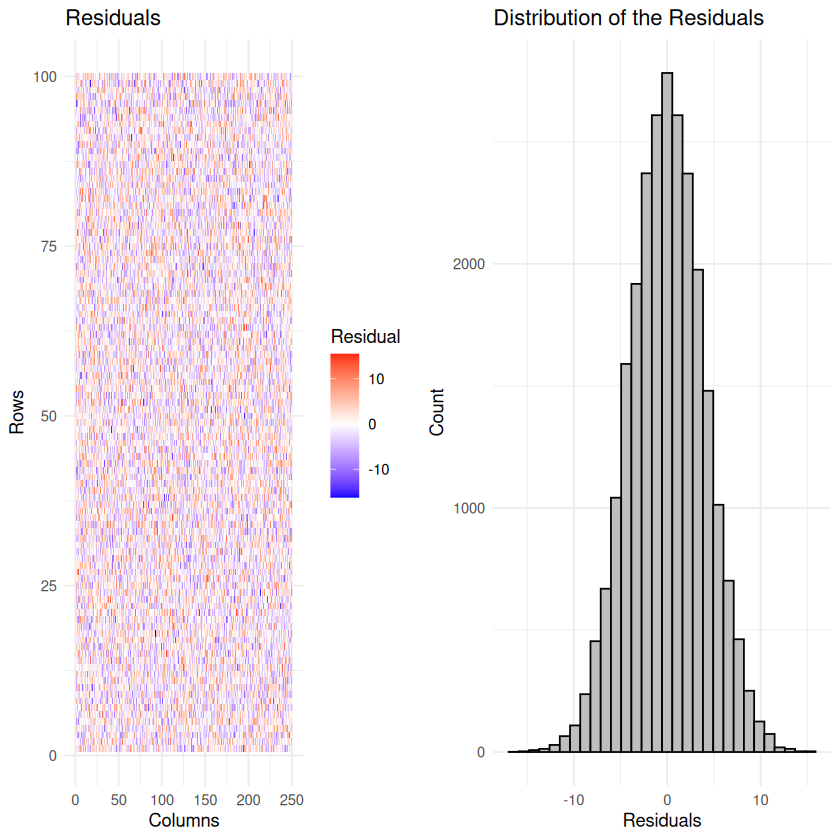

In [19]:
# Reverse row order to match Julia's indexing (end:-1:1)
resids_flipped <- resids[n:1, ]

# Convert residuals matrix into a format suitable for ggplot
resids_melted <- melt(resids_flipped)
colnames(resids_melted) <- c("Row", "Column", "Residual")

# Heatmap of residuals
heatmap_plot <- ggplot(resids_melted, aes(x = Column, y = Row, fill = Residual)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white") +
  theme_minimal() +
  labs(title = "Residuals", x = "Columns", y = "Rows")

# Histogram of residuals
hist_plot <- ggplot(data.frame(Residual = as.vector(resids)), aes(x = Residual)) +
  geom_histogram(bins = 30, fill = "gray", color = "black") +
  theme_minimal() +
  labs(title = "Distribution of the Residuals", x = "Residuals", y = "Count")

# Arrange both plots side by side
grid.arrange(heatmap_plot, hist_plot, ncol = 2)


## T-statistics and permutation test

The t-statistics for an `Mlm` object (defined as `est.B ./ sqrt.(est.varB)`) can be obtained by running `t_stat`. By default, `t_stat` does not return the corresponding t-statistics for any main effects that were estimated by `mlm`, but they will be returned if `isMainEff=true`.

In [20]:
tStats <- MatrixLM$t_stat(est, TRUE)

Permutation p-values for the t-statistics can be computed by the `mlm_perms` function. `mlm_perms` calls the more general function `perm_pvals` and will run the permutations in parallel when possible. The illustrative example below only runs 5 permutations, but a different number can be specified as the second argument. By default, the function used to permute `Y` is `shuffle_rows`, which shuffles the rows for `Y`. Alternative functions for permuting `Y`, such as `shuffle_cols`, can be passed into the argument `permFun`. `mlm_perms` calls `mlm` and `t_stat` , so the user is free to specify keyword arguments for `mlm` or `t_stat`; by default, `mlm_perms` will call both functions using their default behavior.


In [21]:
nPerms <- as.integer(500)
rslts <- MatrixLM$mlm_perms(dat, nPerms, addXIntercept= TRUE, addZIntercept= FALSE, isMainEff=TRUE)
tStats <- rslts[[1]]
pVals <- rslts[[2]]

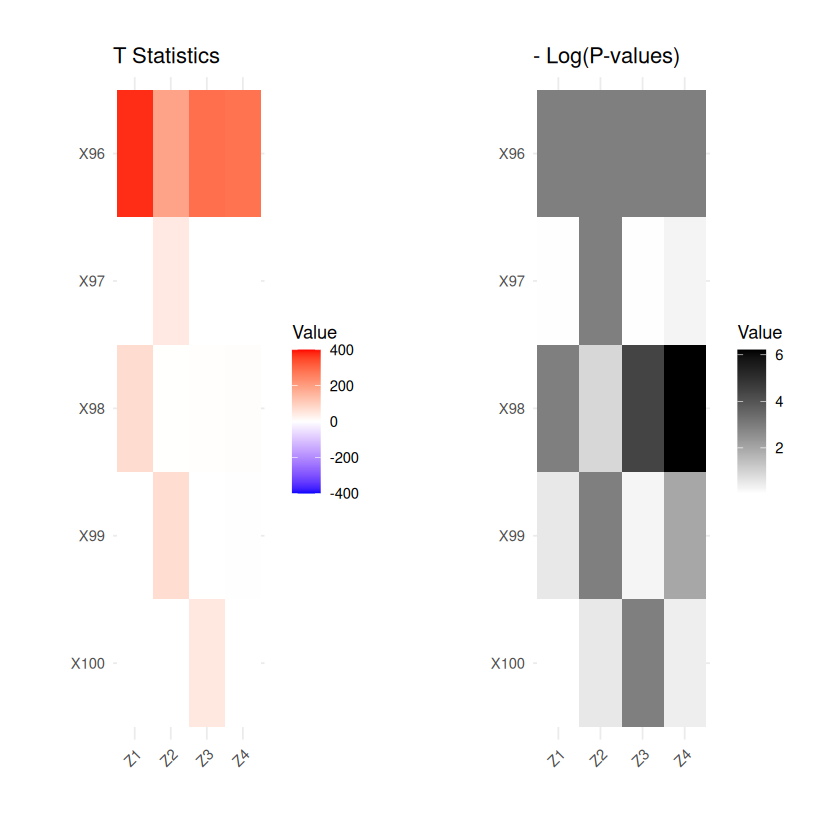

In [22]:
# Reverse row order to match Julia's indexing
tStats <- tStats[dim(tStats)[1]:1, ]
pVals <- pVals[dim(pVals)[1]:1, ]

# Define axis labels
Z_names <- paste0("Z", 1:m)
X_names <- paste0("X", 1:n)

# Convert matrices to data frames for ggplot
tStats_df <- melt(tStats)
colnames(tStats_df) <- c("Y", "X", "Value")
tStats_df$X <- factor(tStats_df$X, levels = 1:m, labels = Z_names)
tStats_df$Y <- factor(tStats_df$Y, levels = 1:n, labels = rev(X_names))

pVals_df <- melt(-log(pVals))
colnames(pVals_df) <- c("Y", "X", "Value")
pVals_df$X <- factor(pVals_df$X, levels = 1:m, labels = Z_names)
pVals_df$Y <- factor(pVals_df$Y, levels = 1:n, labels = rev(X_names))

# Plot tStats heatmap
p1 <- ggplot(tStats_df, aes(x = X, y = Y, fill = Value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0, limits = c(-400, 400)) +
  labs(title = "T Statistics", x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.margin = margin(10, 10, 10, 10, "mm"))

# Plot pVals heatmap
p2 <- ggplot(pVals_df, aes(x = X, y = Y, fill = Value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "black") +
  labs(title = "- Log(P-values)", x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.margin = margin(10, 10, 10, 10, "mm"))

# Combine the plots
grid.arrange(p1, p2, nrow = 1)


In this example, our interpretation of the results can be as follows: 
- the responses $y_{i \in [1, 250]}$ that exhibit the "A" attribute in `Z` show significant differences between level 3 and level 2 of the predictor `catvar` in `X`.
- the responses $y_{i \in [1, 250]}$ that exhibit the "B" attribute in `Z` show significant differences between level 4 and level 3, as well as between level 2 and level 1 of the predictor `catvar` in `X`.
- the responses $y_{i \in [1, 250]}$ that exhibit the "C" attribute in `Z` show significant differences between level 5 and level 4 of the predictor `catvar` in `X`.